In [18]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split

train_data = pd.read_csv('sign_mnist_train.csv')
test_data = pd.read_csv('sign_mnist_test.csv')

In [19]:
# Use DataFrame.head() and DataFrame.tail() to view the top and bottom rows of the frame respectively:
train_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [42]:
train_data = np.array(train_data)
test_data = np.array(test_data)

In [21]:
np.random.shuffle(train_data) # Shuffles all the individual rows
np.random.shuffle(test_data) # Shuffles all the individual rows

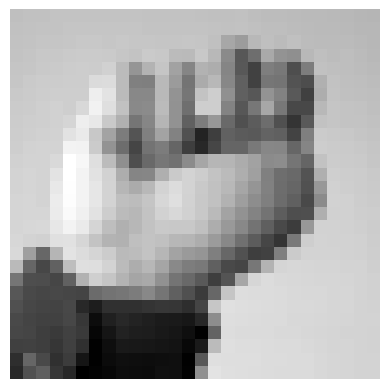

In [43]:
def plot_mnist_image(image_array):
    image = image_array.reshape(28, 28)
    plt.imshow(image, cmap='gray')
    plt.axis('off')  # Turn off axis
    plt.show()

plot_mnist_image(train_data[3, 1:])

In [44]:
X_train = train_data[:, 1:]
Y_train = train_data[:, 0]
X_test = test_data[:, 1:]
Y_test = test_data[:, 0]

In [45]:
X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.long)

In [64]:
# Reshape data to match input dimensions of the CNN
X_train = X_train.view(-1, 1, 28, 28)
X_test = X_test.view(-1, 1, 28, 28)
X_train = X_train/255.
X_test = X_test/255.

In [48]:
X_train.shape

torch.Size([27455, 1, 28, 28])

In [71]:
# Create a dataset and dataloaders
train_dataset = TensorDataset(X_train, Y_train)
test_dataset = TensorDataset(X_test, Y_test)

In [72]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last = True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last = True)

In [100]:
import torch
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self, num_classes=26):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Calculate the input size to the fully connected layer
        self.fc_input_size = 256  # After 4 max pooling layers with kernel size 2

        self.fc1 = nn.Linear(self.fc_input_size, 512)
        self.relu_fc1 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

        self.fc2 = nn.Linear(512, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.pool4(x)

        x = x.view(-1, self.fc_input_size)  # Flatten the tensor

        x = self.fc1(x)
        x = self.relu_fc1(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.softmax(x)

        return x


In [101]:
# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cuda"

model = CNN()

model.to(device)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ReLU

In [102]:
loss_fn = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.1)

In [103]:
# Training the model
n_epochs = 10

batch_size = 64

for epoch in range(n_epochs):
    model.train()
    total_loss = 0.0
    
    for inputs, labels in sample_batches(X_train, Y_train, batch_size):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f'Epoch {epoch+1}, Loss: {total_loss / len(X_train):.4f}')

Epoch 1, Loss: 0.0466
Epoch 2, Loss: 0.0401
Epoch 3, Loss: 0.0383
Epoch 4, Loss: 0.0378
Epoch 5, Loss: 0.0374
Epoch 6, Loss: 0.0369
Epoch 7, Loss: 0.0369
Epoch 8, Loss: 0.0369
Epoch 9, Loss: 0.0369
Epoch 10, Loss: 0.0364


In [104]:
# Function to calculate accuracy
def calculate_accuracy(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    
    with torch.no_grad():  # Disable gradient calculation for efficiency
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

In [105]:
# Calculate accuracy
train_accuracy = calculate_accuracy(model, train_loader, device)
test_accuracy = calculate_accuracy(model, test_loader, device)

print(f'Accuracy on training set: {train_accuracy:.2f}%')
print(f'Accuracy on test set: {test_accuracy:.2f}%')

Accuracy on training set: 100.00%
Accuracy on test set: 97.20%


tensor([16], device='cuda:0')


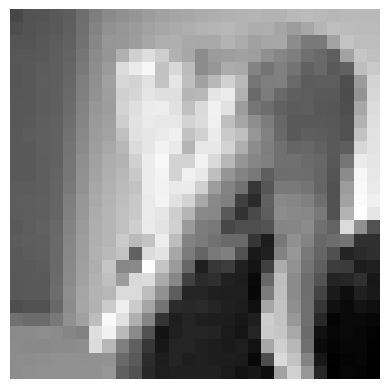

tensor(16)


In [106]:
indice = 4

test = X_train[indice].reshape(1,1,28,28).to(device)

labels = model(test)

label = labels.argmax(1)
print(label)

plot_mnist_image(test.cpu().numpy())

print(Y_train[indice])